# Import Libraries 

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary
import models as cifar_models
import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

# Set the GPU device

In [2]:
# Is GPU available
device = torch.device("cpu")
is_gpu_available = False

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
    is_gpu_available = True
elif torch.backends.mps.is_available():
    print("Apple MPS is available")
    device = torch.device("mps:0")
    is_gpu_available = True

torch.set_default_device(device)

Apple MPS is available


# Download and prepare the dataset

In [3]:
batch_size = 2048
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Data
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Data loaders
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if is_gpu_available else dict(shuffle=True, batch_size=64)

# train dataloader
train_data_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
# test dataloader
test_data_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

# print(exp_data.class_to_idx)
# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Model

# Summary

In [4]:
model = cifar_models.NetBN().to(device)
summary(model=model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
NetBN                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─Conv2d: 1-2                            [1, 64, 32, 32]           18,496
├─Conv2d: 1-3                            [1, 64, 32, 32]           4,160
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Conv2d: 1-5                            [1, 128, 16, 16]          73,856
├─Conv2d: 1-6                            [1, 256, 16, 16]          295,168
├─Conv2d: 1-7                            [1, 512, 16, 16]          1,180,160
├─Conv2d: 1-8                            [1, 512, 16, 16]          262,656
├─MaxPool2d: 1-9                         [1, 512, 8, 8]            --
├─Conv2d: 1-10                           [1, 1024, 8, 8]           4,719,616
├─Conv2d: 1-11                           [1, 2048, 8, 8]           18,876,416
├─Conv2d: 1-12                           

# Define a Loss function and optimizer

In [5]:
criterion = nn.NLLLoss()
optimiser = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

## Train function

In [6]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(
    model: 'torch.nn.Module', 
    train_data_loader: 'torch.utils.data.DataLoader', 
    criterion: 'torch.nn.NLLLoss', 
    optimiser: 'torch.optim.Optimizer', 
    epoch, 
    device = torch.device("cpu")
):
    model.to(device)
    model.train()
    running_loss = 0.0

    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data[0].to(device), data[1].to(device)
        # print(f'inputs shape={inputs.shape} targets shape={targets.shape}')
        
        # zero the parameter gradients
        optimiser.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # forward + backward + optimize
        outputs = model(inputs)
        # print(f'outputs shape={outputs.shape}')

        loss = criterion(outputs, targets)
        train_losses.append(loss)
        
        loss.backward()
        optimiser.step()

        # the class with the highest energy is what we choose as prediction
        predictions = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += predictions.eq(targets.view_as(predictions)).sum().item()
        total += len(inputs)

        
        # print statistics
        train_acc.append(100*correct/total)
        running_loss += loss.item()

        print(f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/total:0.2f}')
    
    return running_loss


## Test function

In [7]:
def test(
    model: 'torch.nn.Module', 
    test_data_loader: 'torch.utils.data.DataLoader', 
    # criterion: 'torch.nn.NLLLoss', 
    # optimiser: 'torch.optim.Optimizer', 
    epoch, 
    device = torch.device("cpu")
):
    model.to(device)
    test_loss = 0
    correct = 0
    total = 0

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    model.eval()
    
    with torch.no_grad():
        for batch_idx, data in enumerate(test_data_loader):
            images, targets = data[0].to(device), data[1].to(device)
            
            # calculate outputs by running images through the network
            outputs = model(images)
            test_loss += F.nll_loss(outputs, targets, reduction='sum').item()  # sum up batch loss
            
            # the class with the highest energy is what we choose as prediction
            predictions = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += predictions.eq(targets.view_as(predictions)).sum().item()
            total += targets.size(0)

            # collect the correct predictions for each class
            for target, prediction in zip(targets, predictions):
                if target == prediction:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    test_loss /= total
    test_losses.append(test_loss)

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
    print(f'Accuracy of the network on the test images: {100. * correct / total} %')
    
    test_acc.append(100. * correct / total)


# Train and test the model

In [8]:
model = cifar_models.NetBN().to(device)
EPOCHS = 1
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, train_data_loader, criterion, optimiser, epoch, device)
    test(model, test_data_loader, epoch, device)

EPOCH: 0
Loss=2.3025431632995605 Batch_id=0 Accuracy=10.25
Loss=2.302762985229492 Batch_id=1 Accuracy=10.40
Loss=2.3027901649475098 Batch_id=2 Accuracy=10.25
Loss=2.302112340927124 Batch_id=3 Accuracy=10.38
Loss=2.30247163772583 Batch_id=4 Accuracy=10.41
Loss=2.3029465675354004 Batch_id=5 Accuracy=10.31
Loss=2.302257776260376 Batch_id=6 Accuracy=10.26
Loss=2.302286386489868 Batch_id=7 Accuracy=10.17
Loss=2.3024775981903076 Batch_id=8 Accuracy=10.26
Loss=2.3029942512512207 Batch_id=9 Accuracy=10.17
Loss=2.302356243133545 Batch_id=10 Accuracy=10.13
Loss=2.3024704456329346 Batch_id=11 Accuracy=10.14
Loss=2.3026890754699707 Batch_id=12 Accuracy=10.20
Loss=2.30267333984375 Batch_id=13 Accuracy=10.09
Loss=2.302783250808716 Batch_id=14 Accuracy=10.01
Loss=2.3028042316436768 Batch_id=15 Accuracy=10.04
Loss=2.302734613418579 Batch_id=16 Accuracy=10.06
Loss=2.302424430847168 Batch_id=17 Accuracy=10.06
Loss=2.30287504196167 Batch_id=18 Accuracy=10.05
Loss=2.302741527557373 Batch_id=19 Accuracy=10

Text(0.5, 1.0, 'Test Accuracy')

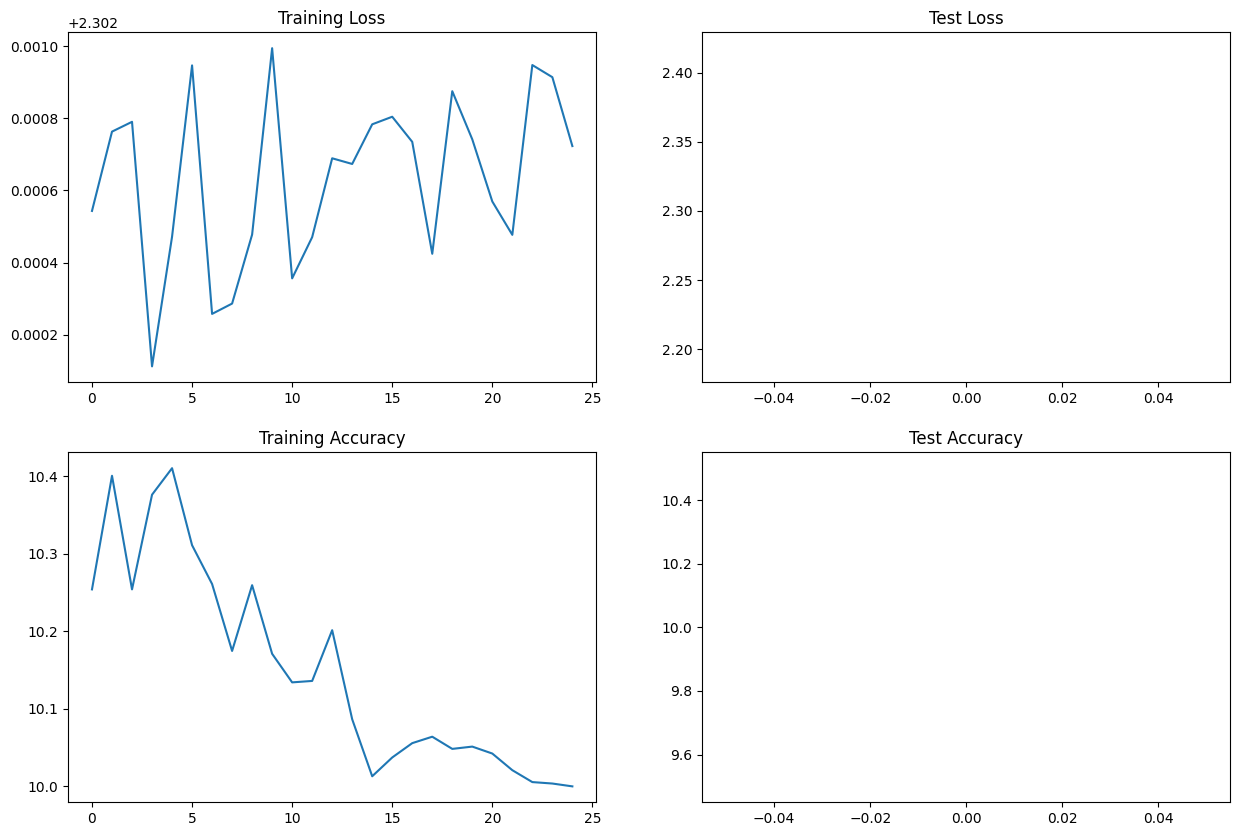

In [9]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")